<a href="https://colab.research.google.com/github/MeenakshiRajpurohit/CMPE-252-AI-and-Data-Engineering/blob/main/Testing_the_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers datasets torch torchvision
!pip install -q accelerate bitsandbytes peft
!pip install -q sentencepiece pillow

print("✓ Packages installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 46.0 MB/s eta 0:00:00
✓ Packages installed!


In [2]:
from google.colab import files
import zipfile

print("Upload your 'finance-vqa-model.zip':")
uploaded = files.upload()

# Extract
zip_filename = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('.')

print("✓ Extracted!")
!ls -la

Upload your 'finance-vqa-model.zip':


Saving finance-vqa-model.zip to finance-vqa-model.zip
✓ Extracted!
total 8164
drwxr-xr-x 1 root root    4096 Feb 14 08:35 .
drwxr-xr-x 1 root root    4096 Feb 14 08:30 ..
drwxr-xr-x 4 root root    4096 Feb  6 14:31 .config
drwxr-xr-x 3 root root    4096 Feb 14 08:35 finance-vqa-gpu-optimized
-rw-r--r-- 1 root root 8337115 Feb 14 08:35 finance-vqa-model.zip
drwxr-xr-x 1 root root    4096 Feb  6 14:31 sample_data


In [3]:
import os

# Your model is in checkpoint-81 folder
MODEL_PATH = "./finance-vqa-gpu-optimized/checkpoint-81"
BASE_MODEL = "naver-clova-ix/donut-base"

# Verify
if os.path.exists(os.path.join(MODEL_PATH, "adapter_config.json")):
    print(f"✅ Model found!")
    !ls -lh {MODEL_PATH}
else:
    print("❌ Model not found!")

✅ Model found!
total 4.7M
-rw-r--r-- 1 root root 1010 Feb 14 08:35 adapter_config.json
-rw-r--r-- 1 root root 3.1M Feb 14 08:35 adapter_model.safetensors
-rw-r--r-- 1 root root 1.6M Feb 14 08:35 optimizer.pt
-rw-r--r-- 1 root root 5.1K Feb 14 08:35 README.md
-rw-r--r-- 1 root root  15K Feb 14 08:35 rng_state.pth
-rw-r--r-- 1 root root 1.4K Feb 14 08:35 scaler.pt
-rw-r--r-- 1 root root 1.5K Feb 14 08:35 scheduler.pt
-rw-r--r-- 1 root root 2.1K Feb 14 08:35 trainer_state.json
-rw-r--r-- 1 root root 5.1K Feb 14 08:35 training_args.bin


In [4]:
import torch
from transformers import DonutProcessor, VisionEncoderDecoderModel
from peft import PeftModel

print("Loading model...")

# Load base model
base_model = VisionEncoderDecoderModel.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Load your adapters
model = PeftModel.from_pretrained(base_model, MODEL_PATH)
model.eval()

# Load processor
processor = DonutProcessor.from_pretrained(BASE_MODEL)

print("✅ Model ready!")

Loading model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/484 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie decoder.model.decoder.embed_tokens.weight to decoder.lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

The image processor of type `DonutImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


tokenizer_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/355 [00:00<?, ?B/s]

✅ Model ready!


In [10]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

def predict(image_input, question, show_image=True):
    # Load image
    if isinstance(image_input, str):
        if image_input.startswith('http'):
            response = requests.get(image_input)
            image = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            image = Image.open(image_input).convert('RGB')
    else:
        image = image_input.convert('RGB')

    if show_image:
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(question)
        plt.show()

    print(f"❓ {question}")

    # Format prompt
    prompt = f"<s_docvqa><s_question>{question}</s_question><s_answer>"

    # Process
    # Cast pixel_values to torch.float16 to match model's expected dtype
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(model.device).to(torch.float16)
    decoder_input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt").input_ids.to(model.device)

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            pixel_values=pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=512,
            early_stopping=True,
        )

    # Decode
    sequence = processor.batch_decode(outputs)[0]
    answer = sequence.split("<s_answer>")[-1].split("</s_answer>")[0].strip()

    print(f"💡 Answer: {answer}\n")
    return answer

print("✓ Function ready!")

✓ Function ready!


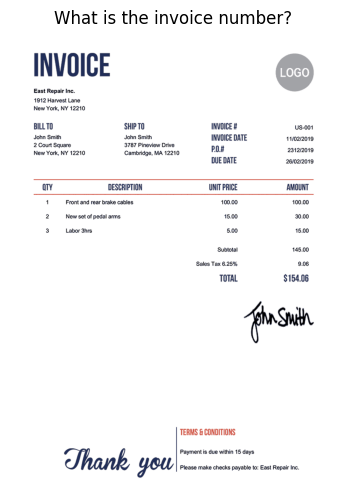

❓ What is the invoice number?
💡 Answer: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>></s>

❓ What is the total amount?
💡 Answer: DATE P.# Cambridge, MA 12210 INVOICE # John Smith 3787 Pineview Drive Cambridge, MA 12210 INVOICE 12101010101011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011

'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>></s>'

In [11]:
# Test with invoice (no upload needed!)
test_url = "https://templates.invoicehome.com/invoice-template-us-neat-750px.png"

response = requests.get(test_url)
test_image = Image.open(BytesIO(response.content)).convert('RGB')

# Test it!
predict(test_image, "What is the invoice number?")
predict(test_image, "What is the total amount?", show_image=False)
predict(test_image, "What is the date?", show_image=False)

Expected: The purpose is to grant approval for specific project funding and budget approval.



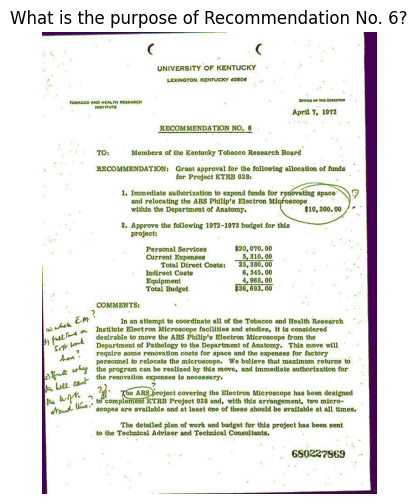

❓ What is the purpose of Recommendation No. 6?
💡 Answer: . TO:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::</s>


Your Model: . TO:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

In [14]:
import json # Import the json module

# Test with actual training data
url = "https://datasets-server.huggingface.co/rows?dataset=sujet-ai%2FSujet-Finance-QA-Vision-100k&config=default&split=train&offset=0&length=1"

response = requests.get(url)
sample = response.json()['rows'][0]['row']

# Get image and question
image = Image.open(BytesIO(requests.get(sample['image']['src']).content)).convert('RGB')

# Parse the qa_pairs JSON string and extract the first question/answer
qa_pair = json.loads(sample['qa_pairs'])[0]
question = qa_pair['question']
ground_truth = qa_pair['answer']

print(f"Expected: {ground_truth}\n")
answer = predict(image, question)

print(f"\nYour Model: {answer}")
print(f"Ground Truth: {ground_truth}")
print(f"Match: {answer.strip() == ground_truth.strip()}")

Upload your financial document:


Saving image.jpg to image.jpg
Your question: what is Total Budget


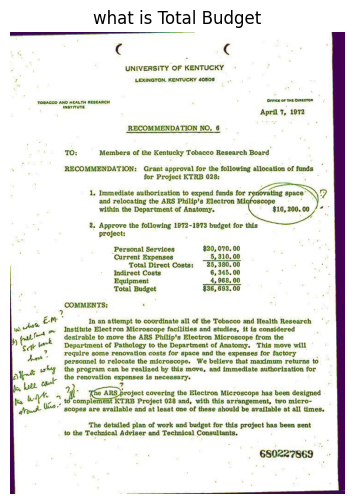

❓ what is Total Budget
💡 Answer: . TOBACCOANDANDANDANDANDANDAND. . TOBACCOANDANDANDANDANDAND. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . </s>



'. TOBACCOANDANDANDANDANDANDAND. . TOBACCOANDANDANDANDANDAND. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . </s>'

In [15]:
print("Upload your financial document:")
uploaded_img = files.upload()

filename = list(uploaded_img.keys())[0]
your_question = input("Your question: ")

predict(filename, your_question)